## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusions)


<a id='intro'></a>
## Introduction


In this analysis, we aim to compare two website versions, the old one and the new one, through an A/B test to determine which version is more effective for the company's future use. To achieve this goal, we will employ three key approaches: probability theory, A/B test techniques, and regression analysis.

**Probability Theory:** This approach will help us evaluate the likelihood of observed differences in key metrics between the two website versions being due to random chance. By calculating p-values and confidence intervals, we can assess the statistical significance of the performance variations.


**A/B Test Techniques:** The A/B test is a crucial component of our analysis, enabling us to compare the old and new website versions under controlled conditions. Through hypothesis testing, we delve into the experimental setup, including the sample size and test duration, while ensuring the test's validity through randomization. This rigorous approach allows us to directly measure the impact of the new website design on user behavior and conversions, providing reliable statistical evidence for decision-making.


**Regression Approach:** Using logistic regression analysis, we will explore the relationships between dependent variables such as click-through rates and conversion rates. Additionally, we will assess the variance inflation factor (VIF) to detect multicollinearity and ensure the reliability of our results. By identifying significant design elements through this approach, we can gain insights into their respective contributions to the overall website performance, helping the company make data-driven decisions for website optimization.

By combining these methodologies, we seek to gain a comprehensive understanding of the performance of each website version and the factors influencing their effectiveness. Our findings will enable the company to make data-driven decisions, ultimately selecting the website design that optimizes user engagement and achieves its business objectives. As with any analysis, it is essential to periodically review the data and reassess the results to account for potential changes in user behavior and preferences.


<a id='probability'></a>
## Part I - Probability

### ToDo 1.1
We will go through our dataset to understand and discover it and look for any problems.

First of all, we import the libraries we're going to use throughout our entire project.

In [457]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
random.seed(42)

Read in the dataset and display the top few rows here:

In [458]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Number of rows in the dataset.

In [417]:
df.shape[0]

294478

The number of unique users in the dataset.

In [418]:
df['user_id'].nunique()

290584

The proportion of users converted.

In [419]:
df.converted.mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [420]:
df[(df['landing_page']!='new_page') & (df['group']=='treatment')].shape[0]+df[(df['landing_page']=='new_page') & (df['group']!='treatment')].shape[0]

3893

Do any of the rows have missing values?

In [421]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2
We will fix the problems we found, and we can see that there are a few rows where `group` and `landing_page` don't match, so we have to remove them.

In [422]:
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Double Check all of the correct rows were removed - this should be 0


In [423]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3
We will go through our dataset again after we modified it to answer some questions that help us in our analysis.

How many rows in df2?

In [424]:
df2.shape[0]

290585

How many unique **user_id**s are in **df2**?

In [425]:
df2["user_id"].nunique()

290584

Who is the user id that is not unique? as we can see there is only 1 user who is duplicated.

In [426]:
df2[df2["user_id"].duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [427]:
df2=df2.drop_duplicates(subset = 'user_id')

### ToDo 1.4
Calculate some possibilities to help us understand more about our data.

What is the probability of an individual converting regardless of the page they receive?

In [428]:
p_pop=df2["converted"].mean()
p_pop

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [429]:
p_control=df2[df2["group"]=="control"]["converted"].mean()
p_control

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [430]:
p_treatment=df2[df2["group"]=="treatment"]["converted"].mean()
p_treatment

0.11880806551510564

What is the actual difference (obs_diff) between the conversion rates for the two groups?

In [431]:
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

What is the probability that an individual received the new page?

In [432]:
df2[df2["landing_page"]=="new_page"].shape[0]/df2.shape[0]

0.5000619442226688

**The population conversion rate for both new and old page groups combined is (0.1195). The old page group has a slightly higher conversion rate of (0.1203), while the new page group has a slightly lower conversion rate of (0.1188), both compared to the overall population rate. The mean difference between the new and old page groups is (-0.0016). Approximately 50% of individuals receive the new page, and the same applies to the old page**

**In conclusion, the analysis suggests that the `old page` may have a minor advantage in driving conversions, but the differences in conversion rates are relatively small. Further analysis and statistical testing may be needed to confirm these observations.**

<a id='ab_test'></a>
## Part II - A/B Test

In the context of continuously running an A/B test with timestamps associated with each event, the challenge lies in determining the appropriate stopping criteria for the test. Two critical questions arise:

1. **Significance Level and Consistency:** Do you halt the test as soon as one page is deemed significantly better than the other, or do you require consistent superiority over a specific duration?

2. **Decision Threshold for Indecisiveness:** How long should the test run to reach a conclusion that neither page is superior to the other?

These questions are the difficult parts associated with A/B tests in general.


### ToDo 2.1
For now, we need to make the decision based on the data provided, so we gonna ask questions to help us to take the right decision ,
We can't determine that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%,
so what should be our null and alternative hypotheses (H0 and H1)?

we can state our hypothesis in terms of words or in terms of  P_old
  and  P_new
 , which are the "converted" probability (or rate) for the old and new pages respectively.

**H0 : P(new) - P(old) <= 0**

**H1 : P(new) - P(old) > 0**

### ToDo 2.2
We will assume that under the null hypothesis, the conversion rates for both the new page, denoted as $p_{new}$, and the old page, denoted as $p_{old}$, are equal. This means that both pages have the same "true" success rate, which is the overall converted success rate found in our dataset regardless of the page.

To conduct the simulation, we will use the sample size for each page as given in our dataset.

Perform the sampling distribution for the difference in conversion rates between the two pages over 10,000 iterations. In each iteration, we will calculate an estimate from the null hypothesis to simulate the random variability that might occur due to sampling.

**convert rate** for $p_{new}$ under the null? 

In [433]:
p_new = p_pop
p_new

0.11959708724499628

**convert rate** for $p_{old}$ under the null? <br><br>

In [434]:
p_old = p_pop
p_new

0.11959708724499628

$n_{new}$ (number of individuals in the treatment group)

In [435]:
n_new = df2[df2["group"]=="treatment"].shape[0]
n_new

145310

$n_{old}$ (number of individuals in the control group)

In [436]:
n_old = df2[df2["group"]=="control"].shape[0]
n_old

145274

We will Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.

In [437]:
new_page_converted = np.random.choice([0,1], size = n_new, p= [1-p_new,p_new])
new_page_converted.mean()

0.12010873305347189

We will Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.

In [438]:
old_page_converted = np.random.choice([0,1], size = n_old, p= [1-p_old,p_old])
old_page_converted.mean()

0.12082685132921238

$p_{new}$ - $p_{old}$ for our simulated values.

In [439]:
p_diff=(new_page_converted.mean()-old_page_converted.mean())
p_diff

-0.0007181182757404897

We will Simulate 10,000 $p_{new}$ - $p_{old}$ values using the same process

In [440]:
p_diffs = []
new_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted - old_converted

We will Plot a histogram of the **p_diffs**.

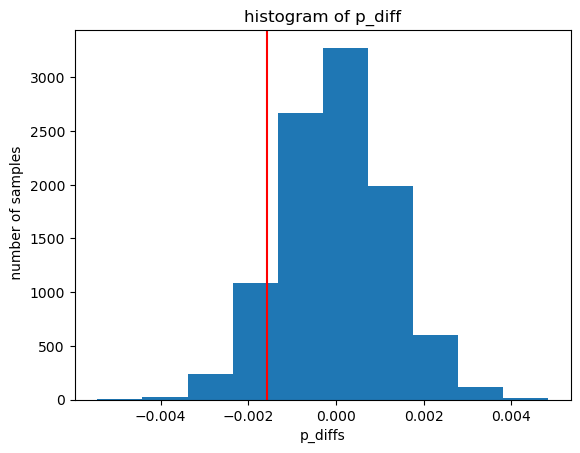

In [441]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color = "r")
plt.title('histogram of p_diff')
plt.xlabel('p_diffs')
plt.ylabel(' number of samples');

**we can say that this problem is right-tailed one,and that the reject area is on the right of the red line ,\
and we can see that is way bigger than fail to reject area**

the proportion of the **p_diffs** that is greater than the actual difference observed in our dataset?

In [442]:
(p_diffs > obs_diff).mean()

0.9056

### we will explain now what we did:
What is this value called in scientific studies? \
What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The P-value is a statistical measure used to determine whether to reject or fail to reject the null hypothesis.**

**If the P-value is greater than the predetermined significance level (often denoted as the Type 1 error rate, set at 0.05), then we fail to reject the null hypothesis. Conversely, if the P-value is less than the significance level (0.05 in this case), we reject the null hypothesis.**

**In this specific scenario, the calculated P-value is 0.9034, which is higher than the significance level of 0.05. Therefore, we conclude that we fail to reject the null hypothesis.**

### ToDo 2.3
We have an alternative option to achieve similar results by utilizing a built-in function. While employing the built-in method may simplify the coding process, it is important to note that the preceding sections provide a step-by-step explanation of the essential concepts for understanding statistical significance.\

To calculate the following parameters, use the corresponding variables:

convert_old: the number of conversions with the old_page.\
convert_new: the number of conversions with the new_page.\
n_old: the number of individuals who were shown the old_page.\
n_new: the number of individuals who were shown the new_page.

In [443]:
convert_old = df2.query('landing_page == "old_page" and converted == True').count()[0]
convert_new = df2.query('landing_page == "new_page" and converted == True').count()[0]
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new = df2.query('landing_page == "new_page"').count()[0]

now we gonna calculate the z_score and and p_value using the built-in method 

In [444]:
z_score, p_value = sm.stats.proportions_ztest(count = [convert_new,convert_old], nobs = [n_new,n_old], alternative='larger')
print(z_score, p_value)


-1.3109241984234394 0.9050583127590245


we gonna calculate the z_alpha

In [445]:
alpha = 0.05 
z_alpha = norm.ppf(1 - alpha)
z_alpha

1.6448536269514722

**Based on the results of the hypothesis test, which involved comparing the Z-score (-1.3) to the critical value (Z_alpha = 1.6) at a significance level of 5%, we find that the Z-score does not exceed the critical value. Consequently, we fail to reject the null hypothesis. Additionally, the corresponding p-value of 0.9 suggests that the observed difference in conversion rates between the old and new page is not statistically significant, so the analysis suggests that the old page may have an advantage in driving more conversions**

<a id='regression'></a>
## Part III - A regression approach

In this part, we will clarify that the result we achieved in the previous A/B test can also be achieved by performing regression. <br><br>

### ToDo 3.1

**We're going to use Logistic Regression because our dataset is binary-categorical.**

We need to clean our dataset first and make it usable for logistic regression, so we will add an intercept column to improve model performance, and we have to do feature engineering by making the dataset have fewer columns.

In [446]:
df2['intercept'] = 1 
df2[['treatment', 'control']]= pd.get_dummies(df2['group'])
df2["ab_page"]=df2["treatment"]
df2 = df2.drop(['control','treatment','group','landing_page'], axis = 1)
df2.head()

,user_id,timestamp,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,0,1,1
1,804228,2017-01-12 08:01:45.159739,0,1,1
2,661590,2017-01-11 16:55:06.154213,0,1,0
3,853541,2017-01-08 18:28:03.143765,0,1,0
4,864975,2017-01-21 01:52:26.210827,1,1,1


we will use **statsmodels** to import our regression model.  Instantiate the model, and fit the model using the two columns we created previously to predict whether or not an individual converts.

In [447]:
model = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Provide the summary of our model below

In [448]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:               8.077e-06
Time:                        18:27:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

**The p-value calculated here is 0.190. And because the logistic Regression is based on a two-tailed test, the p value here differs from what we got previously. 0.190 is still greater than 0.05 (our alpha), so we still cannot reject our null hypothesis.**

### ToDo 3.2
The conversion rate may be related to user characteristics such as nationality, age, gender, or specific cultural behavior. Including more information about users may reveal a hidden value of the new version of the page for a specific group of users.

Now we'll combine our pervios dataset with the countries dataset, which contains the country name of each user id, to see if the user's country influences the conversion rate.

In [449]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [450]:
df_new = df2.join(df_countries.set_index('user_id'), on='user_id')
df_new.head()

,user_id,timestamp,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,0,1,1,US
1,804228,2017-01-12 08:01:45.159739,0,1,1,US
2,661590,2017-01-11 16:55:06.154213,0,1,0,US
3,853541,2017-01-08 18:28:03.143765,0,1,0,US
4,864975,2017-01-21 01:52:26.210827,1,1,1,US


now we gonna Create the necessary dummy variables

In [451]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new=df_new.drop(['country'],axis =1)
df_new.head()

,user_id,timestamp,converted,intercept,ab_page,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,0,1,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,0,1,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,0,1,0,0,0,1
3,853541,2017-01-08 18:28:03.143765,0,1,0,0,0,1
4,864975,2017-01-21 01:52:26.210827,1,1,1,0,0,1


### ToDo 3.3
To reduce collinearity and multicollinearity,ifirst we will implement a variance inflation factor (VIF).

In [452]:
y, X = dmatrices('converted ~ UK + CA + ab_page', df_new, return_type='dataframe')

In [453]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,2.425267,Intercept
1,1.017761,UK
2,1.017759,CA
3,1.000006,ab_page


now we gonna get our dataset results to interpret it 

In [454]:
model2 = sm.Logit(df_new['converted'],df_new[['intercept','CA','UK','ab_page']])
results2 = model2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:               2.323e-05
Time:                        18:27:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0042      0.009   -224.560      0.000      -2.022      -1.987
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
ab_page        0.0149      0.011      1.307      0.191      -0.007       0.037
==============================================================================
"""

**Since some of the coefficients have p-values above 0.05, there is no statistically significant evidence to conclude that regions or new page have a significant impact on the conversion rate.** 

**Because the p-value is greater than a0.05 type 1 error rate ,we fail to reject the null hypothesis.**

**So this approach also suggests keeping the old page.**

### ToDo 3.4
We'll experiment with interacting between UK and ab_page and CA and ab_page to see if it yields more useful results.

In [455]:
df_new['ab_UK'] = df_new['ab_page']*df_new['UK']
df_new['ab_CA'] = df_new['ab_page']*df_new['CA']


In [456]:
model3 = sm.Logit(df_new['converted'],df_new[['intercept','CA', 'UK','ab_page','ab_UK', 'ab_CA']])
results3 = model3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:               3.482e-05
Time:                        18:27:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0070      0.010   -207.045      0.000      -2.026      -1.988
CA            -0.0644      0.038     -1.679      0.093      -0.140       0.011
UK             0.0257      0.019      1.363      0.173      -0.011       0.063
ab_page        0.0206      0.014      1.505      0.132      -0.006       0.047
ab_UK         -0.0314      0.027     -1.181      0.238      -0.084       0.021
ab_CA          0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

**As we can see, we did not obtain any useful results and so failed to reject the null hypothesis.**

<a id='conclusions'></a>
## Conclusion

**After conducting a comprehensive analysis using probability theory, A/B test techniques, and regression analysis to compare the performance of the old and new website versions, we reached a conclusive finding. Despite exploring multiple approaches, all of them led to the same result – we failed to reject the null hypothesis. This means that the observed differences in key metrics between the two versions were not statistically significant and could have occurred by chance.**

**As a result, we recommend that the company continues using the old website, as there is no compelling evidence to suggest that the new version performs better in terms of driving conversions. While continuous improvement is essential, our data-driven approach indicates that the tried and tested old website remains the better choice for achieving the company's goals.**

**It is essential to periodically reassess the website's performance to stay in line with evolving user preferences. Nevertheless, our analysis supports the decision to keep the old website for its demonstrated effectiveness in engaging users and driving conversions. We remain committed to assisting the company with evidence-based decision-making and future optimization endeavors.**